In [4]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
import nltk
import gensim
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF

from sklearn.preprocessing import normalize
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary
!pip install pyLDAvis==2.1.2
import pyLDAvis

import pyLDAvis.gensim

import warnings
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
import numpy as np 
import pandas as pd
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel

In [22]:
import pyLDAvis.gensim

In [5]:
data=pd.read_csv('articles.csv')


In [6]:
data.head(5)

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


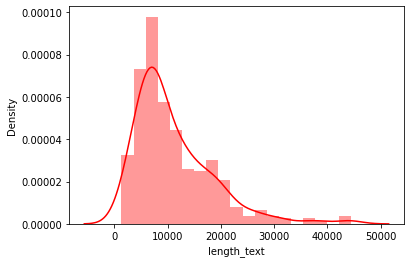

In [7]:
data['length_text'] = data['text'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

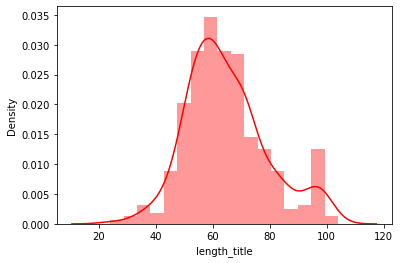

In [8]:
data['length_title'] = data['title'].str.len()
sns.distplot(data['length_title'], color="r")
plt.show()

In [9]:
titles = [x for x in data['title']]
docs = [x for x in data['text']]

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Data Preprocessing
We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word. Filter out stop words.

In [12]:
# A function to prepare the text for topic modelling
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    
    return words

In [13]:
nltk.download('wordnet')
docs = [words(x) for x in data['text']]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 18975
Number of unique words after removing rare and common words: 2720


In [15]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
#print(len(corpus))
#corpus[336]
bow_doc_300 = corpus[300]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))

Word 47 ("close") appears 1 time.
Word 51 ("command") appears 1 time.
Word 65 ("cool") appears 1 time.
Word 121 ("gate") appears 1 time.
Word 189 ("multi") appears 1 time.
Word 213 ("predicted") appears 1 time.
Word 247 ("scene") appears 1 time.
Word 281 ("terminal") appears 1 time.
Word 321 ("column") appears 6 time.
Word 339 ("excellent") appears 1 time.
Word 370 ("matrix") appears 1 time.
Word 431 ("www") appears 1 time.
Word 434 ("additional") appears 1 time.
Word 455 ("collection") appears 3 time.
Word 489 ("github") appears 1 time.
Word 503 ("irrelevant") appears 1 time.
Word 506 ("learning”") appears 1 time.
Word 535 ("ready") appears 1 time.
Word 538 ("relationship") appears 3 time.
Word 571 ("“deep") appears 1 time.
Word 579 ("andrew") appears 1 time.
Word 617 ("guess") appears 1 time.
Word 652 ("neuron") appears 4 time.
Word 736 ("comprehensive") appears 1 time.
Word 767 ("enables") appears 1 time.
Word 774 ("explanation") appears 1 time.
Word 777 ("faced") appears 1 time.
Wo

# Topic Modeling using LDA
LDA :: Latent Dirichlet Allocation is a probabilistic model. It is a unsupervised machine learning technique. And to obtain cluster assignments, it uses two probability values: P( word | topics) and P( topics | documents).

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The size of the bubble measures the importance of the topics, relative to the data.
When we have 5 or 10 topics, we can see certain topics are clustered together (overlapping bubbles), this indicates the similarity between topics.

In [21]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
get_lda_topics(lda_model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,652,1862,1413,601,1062,28,728,420,998,734
1,711,397,1524,2218,716,63,2117,840,2376,1454
2,370,2025,1714,408,823,2278,1647,1456,2361,29
3,1047,20,252,1869,2473,1097,725,1094,915,2434
4,661,1041,1430,265,236,850,1608,315,974,998
5,823,1461,846,2534,1381,12,423,868,1773,2626
6,1543,360,10,2714,810,152,765,1401,901,2427
7,2584,479,1060,1611,2235,48,2127,1446,343,2325
8,1639,386,2579,950,837,236,262,934,939,2436
9,717,1111,1539,2119,1199,44,1410,915,2363,431


In [19]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [24]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.067962 -0.041702       1        1  20.410032
0      0.027138  0.016756       2        1  14.547208
2      0.045017  0.138865       3        1  13.229838
1      0.058198 -0.077311       4        1  11.384638
6      0.071929  0.004283       5        1   8.610154
7      0.011311  0.092837       6        1   7.824379
3      0.065805  0.016254       7        1   7.328669
8     -0.032791 -0.253528       8        1   6.621445
4      0.058602  0.066068       9        1   6.453553
9     -0.373171  0.037477      10        1   3.590083, topic_info=            Term        Freq       Total Category  logprob  loglift
734          cnn  424.000000  424.000000  Default  30.0000  30.0000
601           de  322.000000  322.000000  Default  29.0000  29.0000
29           box  294.000000  294.000000  Default  28.0000  28.0000
998        pixel  288.000000  288.000000  Default  27.0000  27.0000
420        table  213.000000  213.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2538        kera   25.330776  108.062738  Topic10  -5.0948   1.8763
585       author   24.628484  129.485278  Topic10  -5.1230   1.6673
620     identify   21.000010  103.417008  Topic10  -5.2823   1.7327
999      pooling   19.227834   90.157663  Topic10  -5.3705   1.7818
1096  regression   20.630903  144.080153  Topic10  -5.3001   1.3834

[539 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
711       2  0.755123  activation
711       3  0.041440  activation
711       5  0.133528  activation
711       6  0.036835  activation
711       8  0.027626  activation
...     ...       ...         ...
2048      7  0.085902        “big
2048     10  0.042951        “big
1619      3  0.032360         “do
1619      7  0.048539         “do
1619      8  0.906067         “do

[2044 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 2, 7, 8, 4, 9, 5, 10])

The above is the visual representation of the topic modelling and the below is the raw representation and we can specify #words with highest probability to display in each topic. 

In [ ]:
lda_model.save('model10.gensim')
topics = lda_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

In [ ]:
#Performance evaluation by classifying sample document using LDA Bag of Words model
for index, score in sorted(lda_model[corpus[300]], key=lambda tup: -1*tup[1]) :
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 40)))

# Topic Modeling using NMF

In [ ]:
data_text = data[['text']]
data_text = data_text.astype('str')

In [ ]:
articles = [value[0] for value in data_text.iloc[0:].values]

In [ ]:
articles_sentences = [' '.join(text) for text in articles]

In [ ]:
# obtain a Counts design matrix
vectorizer = CountVectorizer(analyzer='word', max_features=1000);
x_counts = vectorizer.fit_transform(articles_sentences);

In [ ]:
# set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer()
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
#normalize the TfIdf values
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
num_topics = 10
model = NMF(n_components=num_topics, init='nndsvd');
model.fit(xtfidf_norm)

In [ ]:
## Get words from each topic 
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
        words = [re.sub('\s+', ' ', sent) for sent in words]
        words = [re.sub("\'", "", sent) for sent in words]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model, 20)

# Cosine Similarity b/w Documents
Given a keyword, Document Recommender system can suggest you the best documents from the pool of documents. 

In [ ]:
words_list=list(chain.from_iterable(docs))

In [ ]:
# Cosine similarity
def cosine_sim(text1, text2):
    tfidf_score = TfidfVectorizer().fit_transform([text1, text2])
    return ((tfidf_score * tfidf_score.T).A)[0, 1]

# Most similar article
def closest_doc_name(sentence, docs):
    cos = []
    for i in range(len(docs)):
        cos.append(cosine_sim(', '.join(sentence.split(' ')),', '.join(docs[i])))
    return [titles[x] for x in np.argsort(cos)[-10:][::-1]]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=words, stop_words=stop_words).fit(words_list)

In [ ]:
closest_doc_name('news', docs)

# References
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df